# How to Build Custom Context Managers in Python
## True power of `with` keyword
<img src='images/bike.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@gijs-coolen-1325695?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Gijs Coolen</a>
        on 
        <a href='https://www.pexels.com/photo/black-bmw-motorcycle-2948297/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Introduction

Programmers often work with external resources such as databases, files, connections, etc. Since these operations are so common, Python has built-in tools called context managers which allow programmers to efficiently handle external sources. The built-in context manager functions might be useful, but there are still many cases where you will need custom context managers.

Under the hood, context managers perform tasks to clean-up any used connections or resources so that they are ready for later. A common use case you might have seen is a context manager that opens a file and closes it after some operation is done:

In [2]:
with open('sample.txt', 'w') as file:
    file.write('Hello World!')

This is the most common pattern to use context managers but there are many others too:

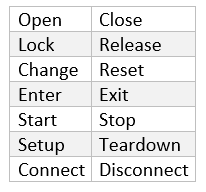

When you are in one of these situations, you will find there are not many built-in functions that come to your aid. Thankfully, you can build one yourself!

### How To Create a Custom Context Manager

There are two ways to build user-defined context-managers:
- class-based
- function-based

Since the first way is a little more complex and some readers may not be familiar with OOP concepts in Python, we will choose equally powerful function-based method.

In this method, there are 5 steps to implement your own context-managers:
1. Define a function.
2. (optional) Write any setup code your context needs.
3. Use the `yield` keyword.
4. (optional) Write any teardown code your context needs.
5. Add the `@contextlib.contextmanager` decorator.

Let's create a simple function:

In [5]:
import contextlib

@contextlib.contextmanager
def my_context():
    print('Welcome!')
    yield
    print('Bye!')

We created a very simple context manager that prints `Welcome` whenever we open the context and as soon as we are outside the context, prints `Bye`. Let's use it before I explain it further:

In [8]:
with my_context():
    print('I am always executed before the yield keyword\n')
print('I am always executed after the yield keyword')

Welcome!
I am always executed before the yield keyword

Bye!
I am always executed after the yield keyword


First of all, to convert a function to a context manager, we need to import `contextlib` module and add `@contextlib.contextmanager` decorator right before the function definition. You don't have to know what decorators are for the scope of this article but here is a [link](https://realpython.com/primer-on-python-decorators/) to a good source if you want to know more.

The second most important step is to add a `yield` keyword. The code you write before `yield` is called setup. In the setup, you should write all the logic that should be executed within the context like connecting to a database, opening a file, etc. 

What comes after `yield` is always executed as soon as you are out of the context. Since Python uses indents for code blocks, writing a single unindented statement indicates Python that we are out of the context. The code that comes after `yield` is also called teardown code. In the teardown, you do operations like closing connections, clearing up resources and so on.

To drive the point home, let's implement a commonly-used timer:

In [11]:
import time

@contextlib.contextmanager
def timer():
    # Start the timer
    start = time.time()
    # context breakdown
    yield
    # End the timer
    end = time.time()
    # Tell the user how much time elapsed
    print(f'This code block executed in {end - start} seconds.')

In [15]:
with timer():
    for i in range(10):
        time.sleep(0.1)
print('Done!')

This code block executed in 1.0053565502166748
Done!


Python starts the timer whenever the interprets sees `with timer():` and ends it (executes `yield` and what comes after) as soon as a new unindented statement is written (`print('Done!')`)

### Building Context Managers That Accept Arguments

Sometimes, we will need context managers that accept arguments and do operations on them in the setup section. For the first example, let's implement the built-in `open` function's context-manager, but only with read-only functionality:

In [17]:
@contextlib.contextmanager
def read_only(path_to_file):
    # Open the file
    file = open(path_to_file, 'r')
    # Context breakdwon
    yield file
    # Close the file
    file.close()

In [22]:
with read_only('sample.txt') as file:
    print('Printing the contents of the file\n')
    print(file.read())

Printing the contents of the file

Sample file


More often than not, when context managers accept arguments they yield the results of the setup code. When a context yields a result, it can be accessed `as` keyword like we are doing in the above `read_only` function.

Here is another example that connects to a `postgreSQL` database and returns the connection:

In [26]:
import psycopg2  # pip install psycopg2, postgres connection adapter


@contextlib.contextmanager
def postgres_connect(user, password, port, database_name, host='127.0.0.1'):
    # Set up a database connection
    connection = psycopg2.connect(host=host,
                                  user=user,
                                  password=password,
                                  port=port,
                                  database=database_name)
    # Yield the connection to be used
    yield connection
    # Close the connection
    connection.close()

```python
with postgres_connect('admin', 'password', '5432', 'sample_db') as conn:
    results = conn.execute("""
        SELECT * FROM my_table
    """)
    print(results.fetchall())

...
```

### Error Handling

It is always a good practice to implement error-handling in your code. Context managers are no exception.

Imagine in our `postgres_connect` function, the user generates an error before the context reaches the teardown. If this ever happens, the connection created to the database using your credentials remains open and you will no longer be able to connect again. To prevent this, we will insert `try-except` statements that close the connection regardless of whether there is an error or not:

In [29]:
@contextlib.contextmanager
def postgres_connect(user, password, port, database_name, host='127.0.0.1'):
    # Set up a database connection
    connection = psycopg2.connect(host=host,
                                  user=user,
                                  password=password,
                                  port=port,
                                  database=database_name)
    try:
        yield connection
    except Exception as e:
        print(e)
    finally:
        # Close the connection
        connection.close()

After the `try-except` statements, adding the `finally` block ensures that the code within `finally` executes no matter what happens. This feature is particularly useful for context managers.

Now, consider this example:

In [30]:
import os

@contextlib.contextmanager
def in_dir(path):
    # Get the current working directory
    cwd = os.getcwd()
    # Change the directory to the desired path
    os.chdir(path)
    try:
        yield
    finally:
        # Change the directory back to home on any occasion
        os.chdir(cwd)

The above manager temporarily changes the working directory that will allow you to perform operations within the context:

In [34]:
with in_dir('data'):
    print(os.listdir())

['sample.txt']


Of course the above code-block could have been executed without a context manager but you get the idea. If we made any errors within the context, the error would be raised but the working directory would be back to where it was.